In [1]:
%cd ~/p/npworks/20200222-Vero-SCV2/

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2


In [2]:
!ls

alignments	       figure-outputs	    raw		   subguppy-leader
annotations	       guppy		    refs	   subguppy-sgRNAs
basemod		       junctions	    run-megalodon  subset-alignments
circos		       launch-guppy-server  scripts	   tmp
colorcode-rainbow.txt  logs		    seqlengths	   tombo-cmd
colorc.py	       mgiseq		    sequences
dualmatch.bed	       minimapcmd	    Snakefile
extra		       poreplex		    stats


In [3]:
print(*['chrSCV', 800, 12000, 'match', '.', '+'], sep='\t', file=open('tmp/nsp23probe.bed', 'w'))
print(*['chrSCV', 29000, 29950, 'match', '.', '+'], sep='\t', file=open('tmp/term3probe.bed', 'w'))

In [4]:
!bedtools intersect -abam alignments/VeroInf24h.viral_genome.linear.sorted.bam -b tmp/nsp23probe.bed -split -s > tmp/nsp23alignments.bam
!bedtools intersect -abam tmp/nsp23alignments.bam -b tmp/term3probe.bed -split -s > tmp/nsp23-intact-alignments.bam

In [5]:
!ls -ahl tmp/nsp23-intact-alignments.bam

-rw-r--r-- 1 hyeshik qbio 107M Mar 27 00:31 tmp/nsp23-intact-alignments.bam


In [6]:
!samtools view -s 0.7 -o tmp/nsp23alignments-subsample.bam tmp/nsp23-intact-alignments.bam

In [7]:
import pysam, re

In [8]:
pat_cigarop = re.compile('([0-9]+)([A-Z])')
def convert_cigar_to_alnblocks(cigarstring, refstart):
    blks = [[refstart, refstart]]

    for length, op in pat_cigarop.findall(cigarstring):
        length = int(length)
        if op in 'MD':
            refstart += length
            blks[-1][1] = refstart
        elif op == 'N':
            refstart += length
            blks.append([refstart, refstart])
    return blks

def trim_alnblocks(blocks, winleft, winright):
    retblk = []
    leftcont = rightcont = False
    for left, right in blocks:
        if right <= winleft:
            leftcont = True
        elif left >= winright:
            rightcont = True
        else:
            retblk.append([max(winleft, left), min(winright, right)])

    if not retblk:
        return [[winleft, winleft], [winright, winright]]

    if leftcont and retblk[0][0] > winleft:
        retblk.insert(0, [winleft, winleft])
    if rightcont and retblk[-1][1] < winright:
        retblk.append([winright, winright])

    return retblk

blocks = convert_cigar_to_alnblocks('19M3D1755N5M2D', 100)
print(blocks)
print(trim_alnblocks(blocks, 150, 1890))

[[100, 122], [1877, 1884]]
[[150, 150], [1877, 1884]]


In [9]:
def transform_coords(x, cutfrom, cutto):
    if x < cutfrom:
        return x
    elif x < cutto:
        return cutfrom
    else:
        return x - cutto + cutfrom

print(transform_coords(100, 500, 1000))
print(transform_coords(700, 500, 1000))
print(transform_coords(1100, 500, 1000))

100
500
600


In [10]:
def trim_alnblocks_discontig(blocks, winleft, winright, cutfrom, cutto):
    cutblocks = trim_alnblocks(blocks, winleft, winright)
    retblk = []
    for blkleft, blkright in cutblocks:
        retblk.append([transform_coords(blkleft, cutfrom, cutto),
                       transform_coords(blkright, cutfrom, cutto)])
    
    if len(retblk) > 2:
        center = [[bleft, bright] for bleft, bright in retblk[1:-1] if bleft < bright]
        return [retblk[0]] + center + [retblk[-1]]
    else:
        return retblk

trim_alnblocks_discontig(blocks, 150, 1880, 1000, 1800)

[[150, 150], [1077, 1080]]

In [11]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [12]:
coverage = \
pd.read_csv('stats/VeroInf24h.viral_genome.coverage.txt', sep='\t',
            names=['chrom', 'pos', 'coverage'])

In [13]:
from scipy.ndimage.filters import percentile_filter

In [14]:
from random import shuffle

In [15]:
covfiltered = percentile_filter(coverage['coverage'], 90, size=11)

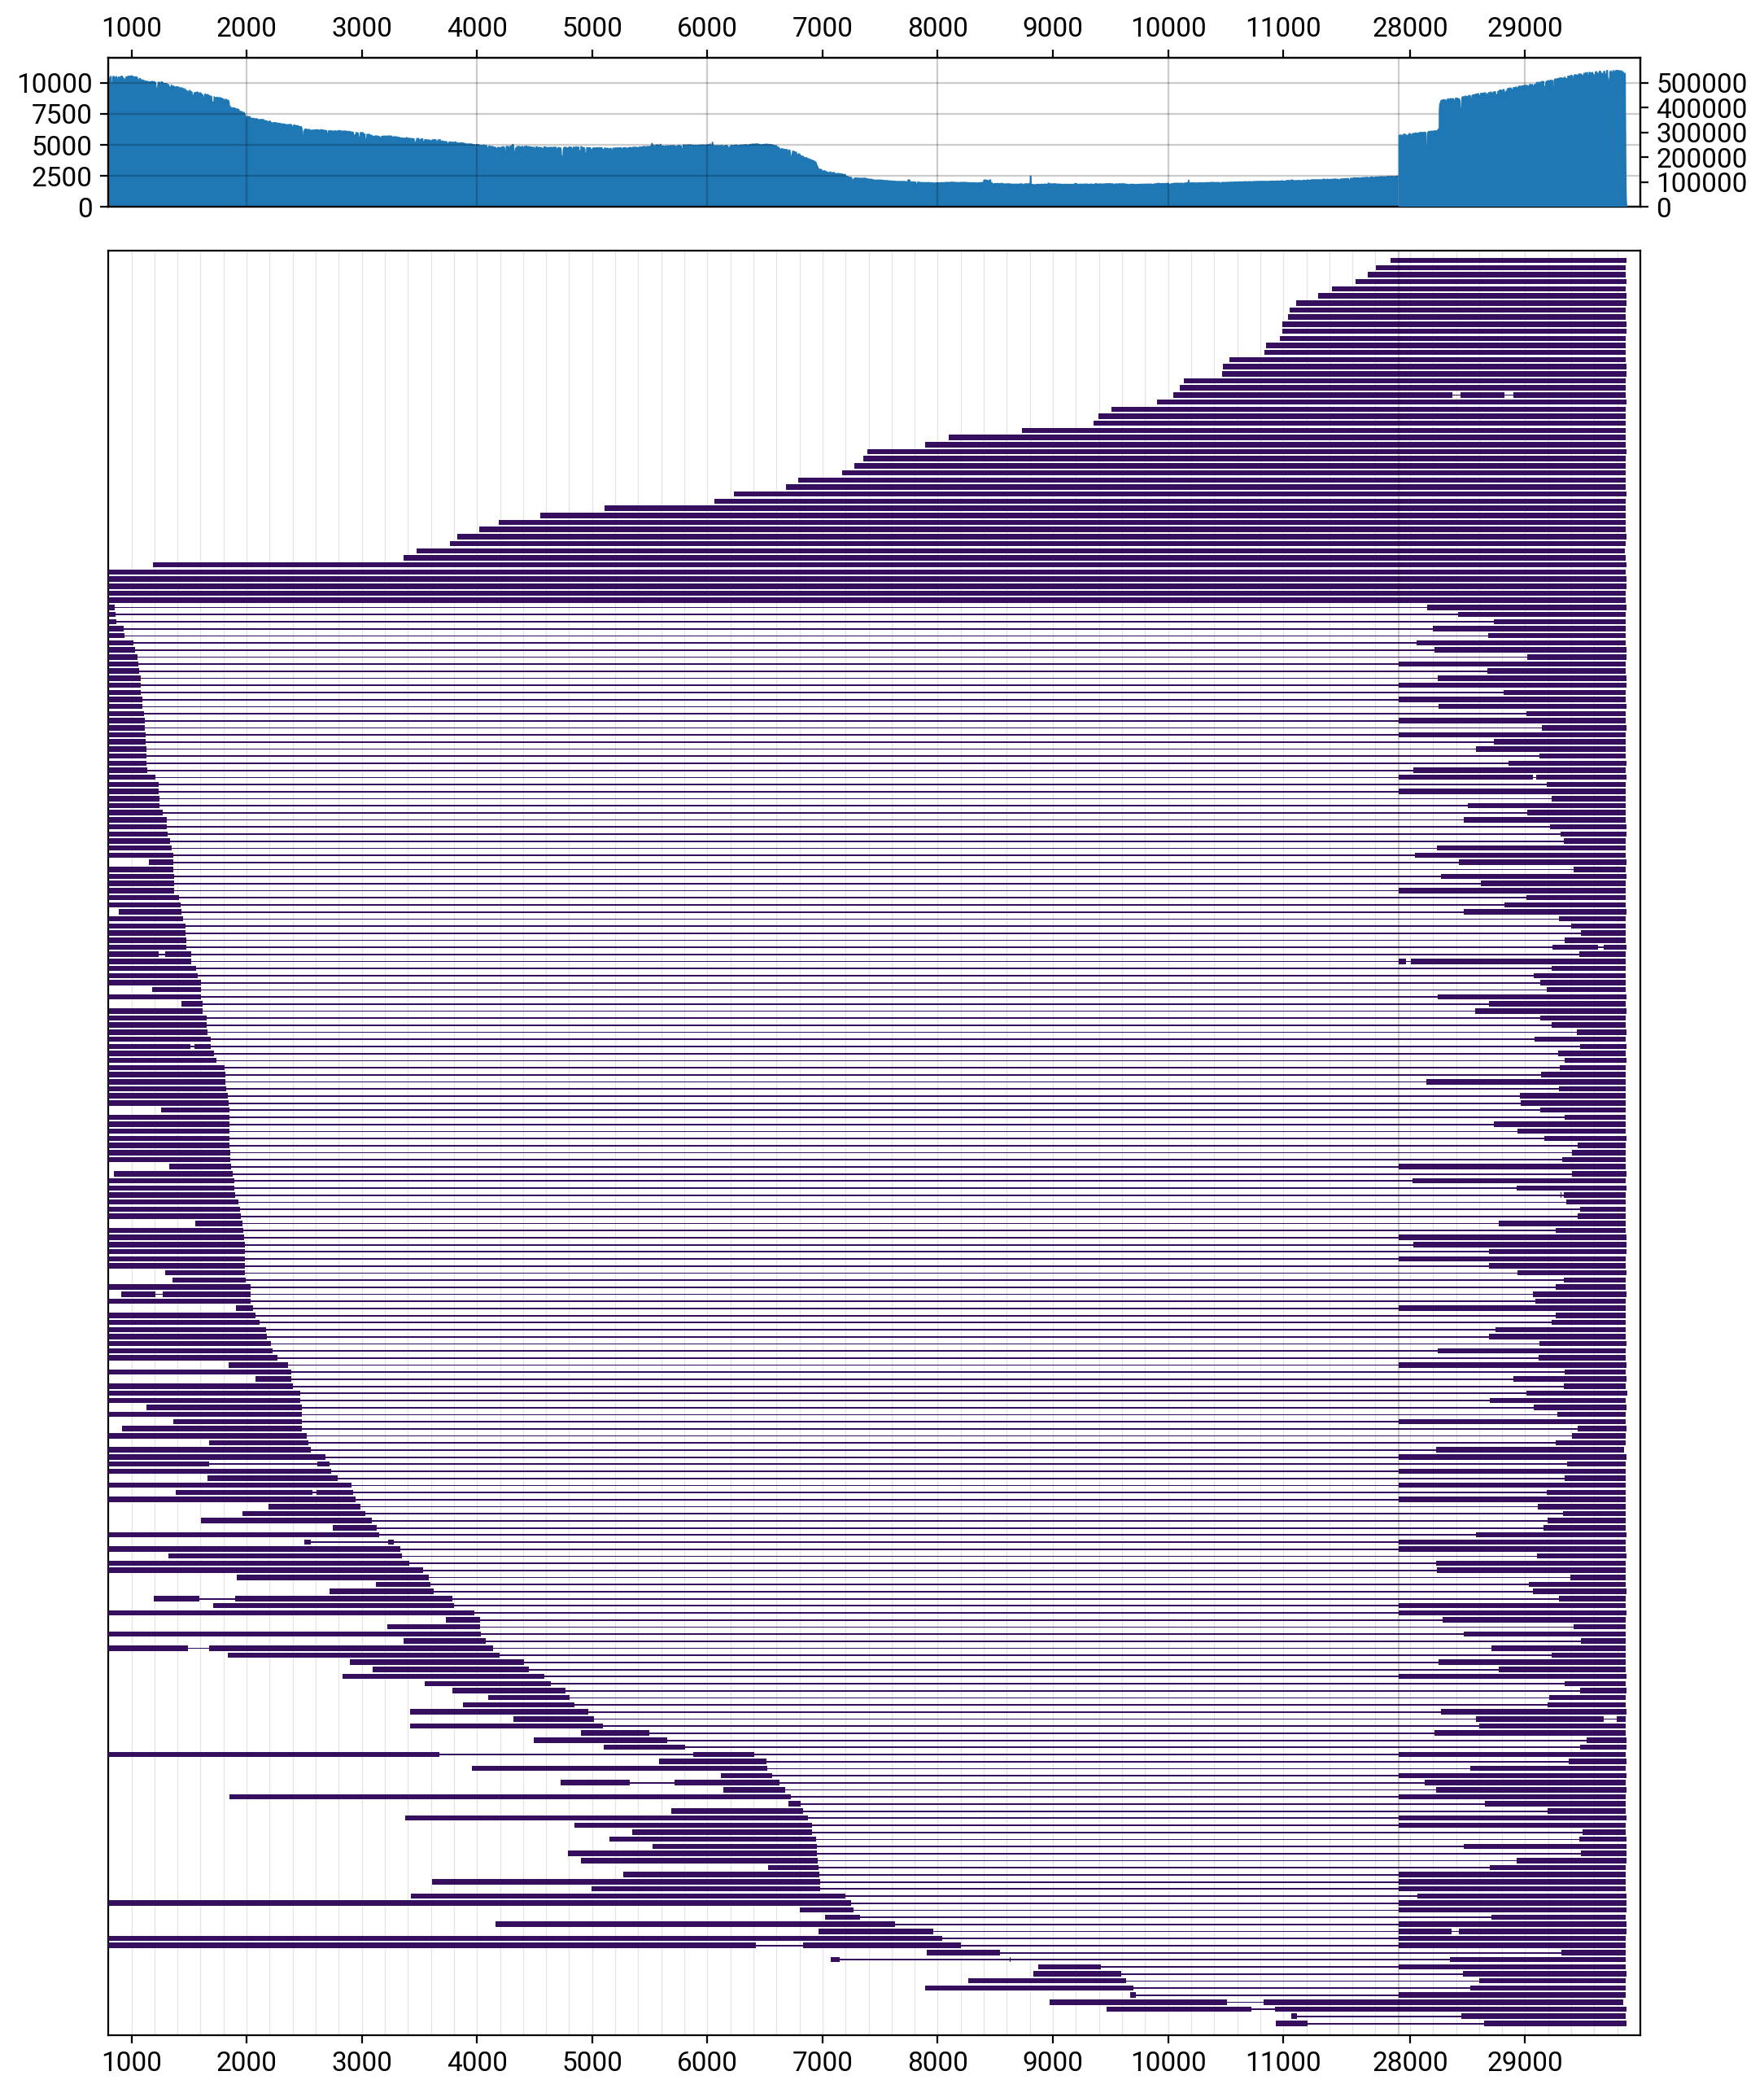

In [16]:
WINLEFT, WINRIGHT = 800, 30000
CUTLEFT, CUTRIGHT = 12000, 27900
TICKSTART = 1000
WINLEFT_XFRM = transform_coords(WINLEFT, CUTLEFT, CUTRIGHT)
WINRIGHT_XFRM = transform_coords(WINRIGHT, CUTLEFT, CUTRIGHT)
MAJORTICKLABELS = list(np.arange(TICKSTART, CUTLEFT, 1000)) + list(np.arange(CUTRIGHT+100, WINRIGHT, 1000))
MAJORTICKS = [transform_coords(x, CUTLEFT, CUTRIGHT) for x in MAJORTICKLABELS]
MINORTICKLABELS = list(np.arange(TICKSTART, CUTLEFT, 200)) + list(np.arange(CUTRIGHT+100, WINRIGHT, 200))
MINORTICKS = [transform_coords(x, CUTLEFT, CUTRIGHT) for x in MINORTICKLABELS]
BARWIDTH = 0.8
BARCENTER = BARWIDTH / 2
BACKBONEWIDTH = 0.2
MINIMUM_MAPPED = 1000
COVERAGE_RESOLUTION = 50
VERTICAL_MARGIN = 1
NUMALIGNMENTS = 250
INTACT_END = transform_coords(29850, CUTLEFT, CUTRIGHT)
MINIMUM_FIRST_BLOCK_SIZE = 50
XGRIDS = [2000, 4000, 6000, 8000, 10000, 12000, 29000]
XGRIDS = [transform_coords(x, CUTLEFT, CUTRIGHT) for x in XGRIDS]


fig, axes = plt.subplots(2, 1, figsize=(11, 13), gridspec_kw={'height_ratios': [1, 12]})

covblk1_x = np.arange(WINLEFT, CUTLEFT)
covblk2_x = np.arange(CUTRIGHT, min(WINRIGHT, len(covfiltered)))
covblk1_x_xfrm = list(transform_coords(x, CUTLEFT, CUTRIGHT) for x in covblk1_x)
covblk2_x_xfrm = list(transform_coords(x, CUTLEFT, CUTRIGHT) for x in covblk2_x)
covblk1_y = covfiltered[covblk1_x]
covblk2_y = covfiltered[covblk2_x]

ax = axes[0]
ax.xaxis.tick_top()
ax.set_xlim(WINLEFT_XFRM, WINRIGHT_XFRM)
ax.set_xticks(MAJORTICKS)
ax.set_xticklabels(MAJORTICKLABELS)
ax.fill_between(covblk1_x_xfrm, 0, covblk1_y, zorder=3)
ax.set_ylim(0, 12000)
ax.set_yticks(np.arange(0, 10001, 2500))
for i in np.arange(0, 10001, 2500):
    ax.axhline(i, c='black', lw=.8, zorder=5, alpha=.2)

for x in XGRIDS:
    ax.axvline(x, c='black', lw=.8, zorder=5, alpha=.2)
    
ax = ax.twinx()
ax.fill_between(covblk2_x_xfrm, 0, covblk2_y, zorder=3)
ax.set_yticks(np.arange(0, 600000, 100000))
#for i in np.arange(0, 600001, 10000):
#    ax.axhline(i, c='black', lw=.8, zorder=5, alpha=.2)
ax.set_ylim(0, 600000)

ax = axes[1]
alnno = 0

intact_alignments = []
with pysam.AlignmentFile('tmp/nsp23alignments-subsample.bam') as alnfile:

    for aln in alnfile:
        blocks = convert_cigar_to_alnblocks(aln.cigarstring, aln.reference_start)
        blocks = trim_alnblocks_discontig(blocks, WINLEFT, WINRIGHT, CUTLEFT, CUTRIGHT)
        totalmapped = sum(right-left for left, right in blocks)
        if totalmapped < MINIMUM_MAPPED:
            continue
        elif blocks[-1][1] < INTACT_END:
            continue
        elif blocks[0][1] - blocks[0][0] < MINIMUM_FIRST_BLOCK_SIZE:
            continue

        if len(blocks) > 1:
            gapft = max(
                (gapright - gapleft, gapleft, gapright)
                for (_, gapleft), (gapright, _) in zip(blocks[:-1], blocks[1:]))
        
            if gapft[0] < 100:
                gapft = (100000, -1, -blocks[0][0])
        else:
            gapft = (100000, -1, -blocks[0][0])

        intact_alignments.append((gapft[1:], blocks))

shuffle(intact_alignments)
for alnno, (_, blocks) in enumerate(sorted(intact_alignments[:NUMALIGNMENTS])):
    blkpatches = []
    for blkleft, blkright in blocks:
        if blkright - blkleft < 5:
            continue
        rect = Rectangle((blkleft, alnno), blkright-blkleft, 0.75)
        blkpatches.append(rect)

    pc = PatchCollection(blkpatches, fc='#350e5e', edgecolor='none', zorder=3)
    ax.add_collection(pc)

    rect = Rectangle((blocks[0][0], alnno + BARCENTER - BACKBONEWIDTH/2),
                     blocks[-1][1] - blocks[0][0], BACKBONEWIDTH)
    pc = PatchCollection([rect], fc='#350e5e', edgecolor='none', zorder=2)
    ax.add_collection(pc)

ax.set_xlim(WINLEFT_XFRM, WINRIGHT_XFRM)
ax.set_ylim(alnno + VERTICAL_MARGIN * 2, -VERTICAL_MARGIN)
ax.set_xticks(MAJORTICKS)
ax.set_xticklabels(MAJORTICKLABELS)
for x in XGRIDS:
    if x not in MINORTICKS:
        ax.axvline(x, c='black', lw=.8, zorder=5, alpha=.2)

for mt in MINORTICKS:
    ax.axvline(mt, c='black', lw=.5, alpha=.1, zorder=1)

plt.setp(ax.get_yticklines(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
    
plt.tight_layout()
plt.savefig('figure-outputs/alignment.pdf')